# Neural Receiver for OFDM SIMO Systems

In this notebook, you will learn how to train a neural receiver that implements OFDM detection.
The considered setup is shown in the figure below.
As one can see, the neural receiver substitutes channel estimation, equalization, and demapping.
It takes as input the post-DFT (discrete Fourier transform) received samples, which form the received resource grid, and computes log-likelihood ratios (LLRs) on the transmitted coded bits.
These LLRs are then fed to the outer decoder to reconstruct the transmitted information bits.

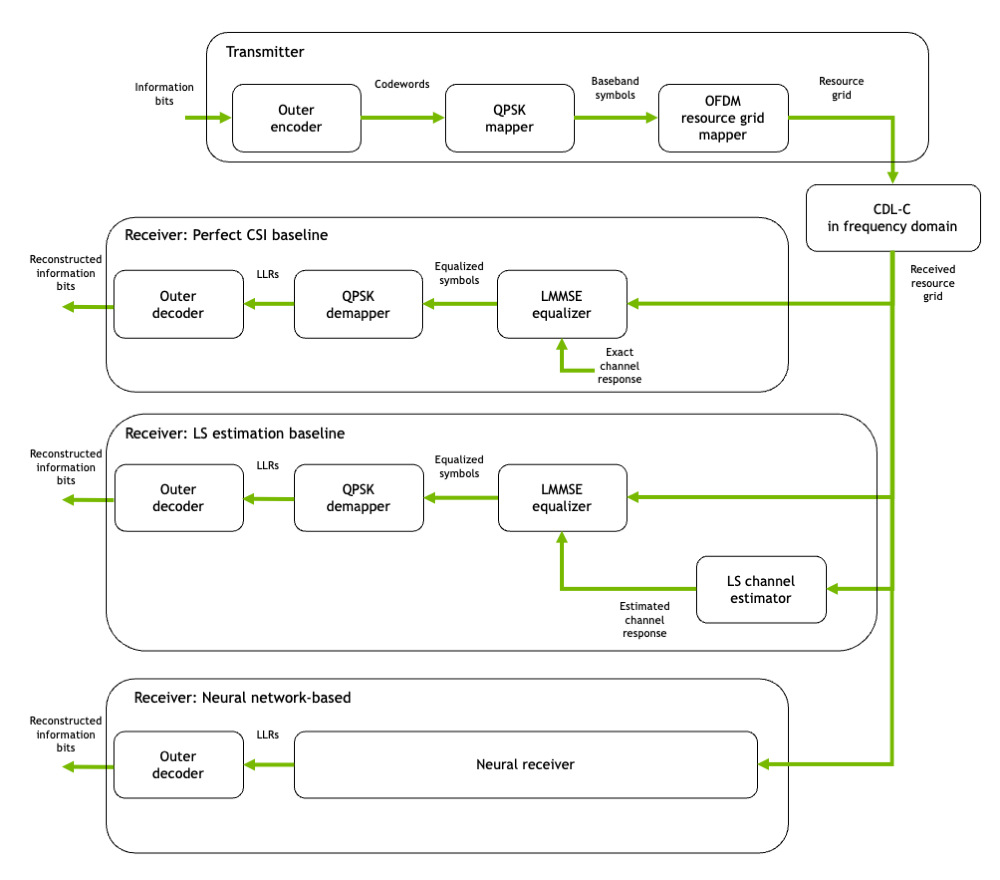

Two baselines are considered for benchmarking, which are shown in the figure above.
Both baselines use linear minimum mean square error (LMMSE) equalization and demapping assuming additive white Gaussian noise (AWGN).
They differ by how channel estimation is performed:

- **Pefect CSI**: Perfect channel state information (CSI) knowledge is assumed.
- **LS estimation**: Uses the transmitted pilots to perform least squares (LS) estimation of the channel with nearest-neighbor interpolation.

All the considered end-to-end systems use an LDPC outer code from the 5G NR specification, QPSK modulation, and a 3GPP CDL channel model simulated in the frequency domain.

* [GPU Configuration and Imports](#GPU-Configuration-and-Imports)
* [Simulation Parameters](#Simulation-Parameters)
* [Neural Receiver](#Neural-Receiver)
* [End-to-end System](#End-to-end-System)
* [End-to-end System as a Sionna Block](#End-to-end-System-as-a-Sionna-Block)
* [Evaluation of the Baselines](#Evaluation-of-the-Baselines)
* [Training the Neural Receiver](#Training-the-Neural-Receiver)
* [Evaluation of the Neural Receiver](#Evaluation-of-the-Neural-Receiver)
* [Pre-computed Results](#Pre-computed-Results)
* [References](#References)

## GPU Configuration and Imports <a class="anchor" id="GPU-Configuration-and-Imports"></a>

In [ ]:
import os
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna.phy
except ImportError as e:
    import sys
    if 'google.colab' in sys.modules:
       # Install Sionna in Google Colab
       print("Installing Sionna and restarting the runtime. Please run the cell again.")
       os.system("pip install sionna")
       os.kill(os.getpid(), 5)
    else:
       raise e

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

sionna.phy.config.seed = 42 # Set seed for reproducible random number generation

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle

from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, Conv2D, LayerNormalization
from tensorflow.nn import relu

from sionna.phy import Block
from sionna.phy.channel.tr38901 import Antenna, AntennaArray, CDL
from sionna.phy.channel import OFDMChannel
from sionna.phy.mimo import StreamManagement
from sionna.phy.ofdm import ResourceGrid, ResourceGridMapper, LSChannelEstimator, \
                            LMMSEEqualizer, RemoveNulledSubcarriers, ResourceGridDemapper
from sionna.phy.utils import  ebnodb2no, insert_dims, log10, expand_to_rank
from sionna.phy.fec.ldpc import LDPC5GEncoder, LDPC5GDecoder
from sionna.phy.mapping import Mapper, Demapper, BinarySource
from sionna.phy.utils import sim_ber

## Simulation Parameters <a class="anchor" id="Simulation-Parameters"></a>

In [ ]:
############################################
## Channel configuration
carrier_frequency = 3.5e9 # Hz
delay_spread = 100e-9 # s
cdl_model = "E" # CDL model to use
speed = 10.0 # Speed for evaluation and training [m/s]
# SNR range for evaluation and training [dB]
ebno_db_min = -5.0
ebno_db_max = 10.0

############################################
## OFDM waveform configuration
subcarrier_spacing = 30e3 # Hz
fft_size = 128 # Number of subcarriers forming the resource grid, including the null-subcarrier and the guard bands
num_ofdm_symbols = 14 # Number of OFDM symbols forming the resource grid
dc_null = True # Null the DC subcarrier
num_guard_carriers = [5, 6] # Number of guard carriers on each side
pilot_pattern = "kronecker" # Pilot pattern
pilot_ofdm_symbol_indices = [2, 11] # Index of OFDM symbols carrying pilots
cyclic_prefix_length = 0 # Simulation in frequency domain. This is useless

############################################
## Modulation and coding configuration
num_bits_per_symbol = 2 # QPSK
coderate = 0.5 # Coderate for LDPC code

############################################
## Neural receiver configuration
num_conv_channels = 128 # Number of convolutional channels for the convolutional layers forming the neural receiver

############################################
## Training configuration
num_training_iterations = 12000 # Number of training iterations
training_batch_size = 128 # Training batch size
model_weights_path = "neural_receiver_weights_CBAM_E" # Location to save the neural receiver weights once training is done

############################################
## Evaluation configuration
results_filename = "neural_receiver_results_CBAM_E" # Location to save the results

The `StreamManagement` class is used to configure the receiver-transmitter association and the number of streams per transmitter.
A SIMO system is considered, with a single transmitter equipped with a single non-polarized antenna.
Therefore, there is only a single stream, and the receiver-transmitter association matrix is $[1]$.
The receiver is equipped with an antenna array.

In [ ]:
stream_manager = StreamManagement(np.array([[1]]), # Receiver-transmitter association matrix
                                  1)               # One stream per transmitter

The `ResourceGrid` class is used to configure the OFDM resource grid. It is initialized with the parameters defined above.

In [ ]:
resource_grid = ResourceGrid(num_ofdm_symbols = num_ofdm_symbols,
                             fft_size = fft_size,
                             subcarrier_spacing = subcarrier_spacing,
                             num_tx = 1,
                             num_streams_per_tx = 1,
                             cyclic_prefix_length = cyclic_prefix_length,
                             dc_null = dc_null,
                             pilot_pattern = pilot_pattern,
                             pilot_ofdm_symbol_indices = pilot_ofdm_symbol_indices,
                             num_guard_carriers = num_guard_carriers)

Outer coding is performed such that all the databits carried by the resource grid with size `fft_size`x`num_ofdm_symbols` form a single codeword.

In [ ]:
# Codeword length. It is calculated from the total number of databits carried by the resource grid, and the number of bits transmitted per resource element
n = int(resource_grid.num_data_symbols*num_bits_per_symbol)
# Number of information bits per codeword
k = int(n*coderate)

The SIMO link is setup by considering an uplink transmission with one user terminal (UT) equipped with a single non-polarized antenna, and a base station (BS) equipped with an antenna array.
One can try other configurations for the BS antenna array.

In [ ]:
ut_antenna = Antenna(polarization="single",
                     polarization_type="V",
                     antenna_pattern="38.901",
                     carrier_frequency=carrier_frequency)

bs_array = AntennaArray(num_rows=1,
                        num_cols=1,
                        polarization="dual",
                        polarization_type="VH",
                        antenna_pattern="38.901",
                        carrier_frequency=carrier_frequency)

## Neural Receiver <a class="anchor" id="Neural-Receiver"></a>

The next cell defines the Keras layers that implement the neural receiver.
As in [1] and [2], a neural receiver using residual convolutional layers is implemented. Convolutional layers are leveraged to efficienly process the 2D resource grid, that is fed as an input to the neural receiver.
Residual (skip) connections are used to avoid gradient vanishing [3].

For convinience, a Keras layer that implements a *residual block* is first defined. The Keras layer that implements the neural receiver is built by stacking such blocks. The following figure shows the architecture of the neural receiver.

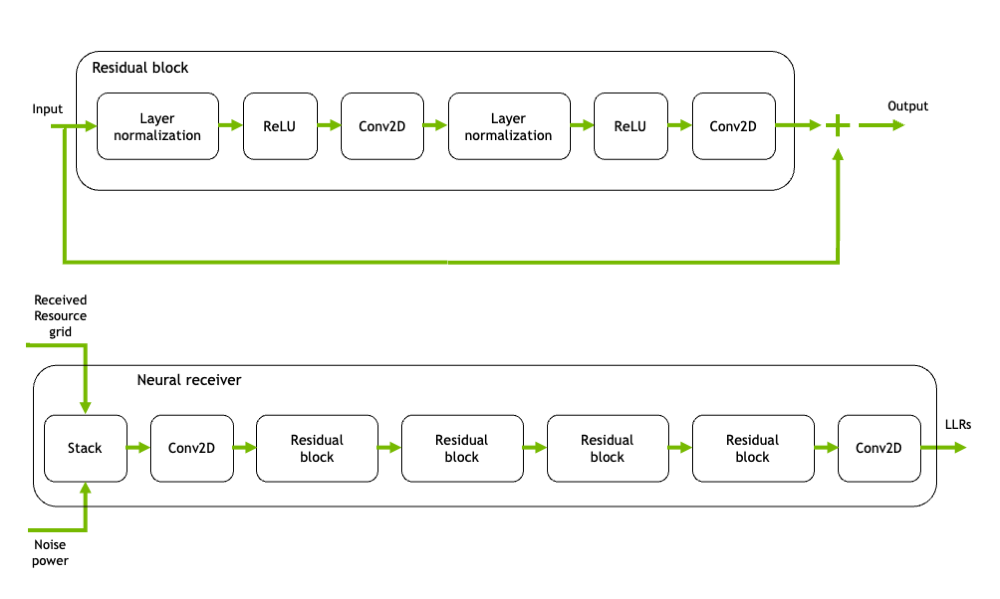

In [ ]:
class ResidualBlock(Layer):

    def build(self, input_shape):

        # Layer normalization is done over the last three dimensions: time, frequency, conv 'channels'
        self._layer_norm_1 = LayerNormalization(axis=(-1, -2, -3))
        self._conv_1 = Conv2D(filters=num_conv_channels,
                              kernel_size=[3,3],
                              padding='same',
                              activation=None)
        # Layer normalization is done over the last three dimensions: time, frequency, conv 'channels'
        self._layer_norm_2 = LayerNormalization(axis=(-1, -2, -3))
        self._conv_2 = Conv2D(filters=num_conv_channels,
                              kernel_size=[3,3],
                              padding='same',
                              activation=None)

    def call(self, inputs):
        z = self._layer_norm_1(inputs)
        z = relu(z)
        z = self._conv_1(z)
        z = self._layer_norm_2(z)
        z = relu(z)
        z = self._conv_2(z) # [batch size, num time samples, num subcarriers, num_channels]
        # Skip connection
        z = z + inputs

        return z

class NeuralReceiver(Layer):

    def build(self, input_shape):

        # Input convolution
        self._input_conv = Conv2D(filters=num_conv_channels,
                                  kernel_size=[3,3],
                                  padding='same',
                                  activation=None)
        # Residual blocks
        self._res_block_1 = ResidualBlock()
        self._res_block_2 = ResidualBlock()
        self._res_block_3 = ResidualBlock()
        self._res_block_4 = ResidualBlock()
        # Output conv
        self._output_conv = Conv2D(filters=num_bits_per_symbol,
                                   kernel_size=[3,3],
                                   padding='same',
                                   activation=None)

    def call(self, y, no):

        # Feeding the noise power in log10 scale helps with the performance
        no = log10(no)

        # Stacking the real and imaginary components of the different antennas along the 'channel' dimension
        y = tf.transpose(y, [0, 2, 3, 1]) # Putting antenna dimension last
        no = insert_dims(no, 3, 1)
        no = tf.tile(no, [1, y.shape[1], y.shape[2], 1])
        # z : [batch size, num ofdm symbols, num subcarriers, 2*num rx antenna + 1]
        z = tf.concat([tf.math.real(y),
                       tf.math.imag(y),
                       no], axis=-1)
        # Input conv
        z = self._input_conv(z)
        # Residual blocks
        z = self._res_block_1(z)
        z = self._res_block_2(z)
        z = self._res_block_3(z)
        z = self._res_block_4(z)
        # Output conv
        z = self._output_conv(z)

        return z

## End-to-end System <a class="anchor" id="End-to-end-System"></a>

The following cell defines the end-to-end system.

Training is done on the bit-metric decoding (BMD) rate which is computed from the transmitted bits and LLRs:

\begin{equation}
R = 1 - \frac{1}{SNMK} \sum_{s = 0}^{S-1} \sum_{n = 0}^{N-1} \sum_{m = 0}^{M-1} \sum_{k = 0}^{K-1} \texttt{BCE} \left( B_{s,n,m,k}, \texttt{LLR}_{s,n,m,k} \right)
\end{equation}

where

* $S$ is the batch size
* $N$ the number of subcarriers
* $M$ the number of OFDM symbols
* $K$ the number of bits per symbol
* $B_{s,n,m,k}$ the $k^{th}$ coded bit transmitted on the resource element $(n,m)$ and for the $s^{th}$ batch example
* $\texttt{LLR}_{s,n,m,k}$ the LLR (logit) computed by the neural receiver corresponding to the $k^{th}$ coded bit transmitted on the resource element $(n,m)$ and for the $s^{th}$ batch example
* $\texttt{BCE} \left( \cdot, \cdot \right)$ the binary cross-entropy in log base 2

Because no outer code is required at training, the outer encoder and decoder are not used at training to reduce computational complexity.

The BMD rate is known to be an achievable information rate for BICM systems, which motivates its used as objective function [4].

In [ ]:
## Transmitter
binary_source = BinarySource()
mapper = Mapper("qam", num_bits_per_symbol)
rg_mapper = ResourceGridMapper(resource_grid)

## Channel
cdl = CDL(cdl_model, delay_spread, carrier_frequency,
          ut_antenna, bs_array, "uplink", min_speed=speed)
channel = OFDMChannel(cdl, resource_grid, normalize_channel=True, return_channel=True)

## Receiver
neural_receiver = NeuralReceiver()
rg_demapper = ResourceGridDemapper(resource_grid, stream_manager) # Used to extract data-carrying resource elements

The following cell performs one forward step through the end-to-end system:

In [ ]:
batch_size = 64
ebno_db = tf.fill([batch_size], 5.0)
no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate)


## Transmitter
# Generate codewords
c = binary_source([batch_size, 1, 1, n])
print("c shape: ", c.shape)
# Map bits to QAM symbols
x = mapper(c)
print("x shape: ", x.shape)
# Map the QAM symbols to a resource grid
x_rg = rg_mapper(x)
print("x_rg shape: ", x_rg.shape)

######################################
## Channel
# A batch of new channel realizations is sampled and applied at every inference
no_ = expand_to_rank(no, tf.rank(x_rg))
y,_ = channel(x_rg, no_)
print("y shape: ", y.shape)

######################################
## Receiver
# The neural receiver computes LLRs from the frequency domain received symbols and N0
y = tf.squeeze(y, axis=1)
llr = neural_receiver(y, no)
print("llr shape: ", llr.shape)
# Reshape the input to fit what the resource grid demapper is expected
llr = insert_dims(llr, 2, 1)
# Extract data-carrying resource elements. The other LLRs are discarded
llr = rg_demapper(llr)
llr = tf.reshape(llr, [batch_size, 1, 1, n])
print("Post RG-demapper LLRs: ", llr.shape)

c shape:  (64, 1, 1, 2784)
x shape:  (64, 1, 1, 1392)
x_rg shape:  (64, 1, 1, 14, 128)
y shape:  (64, 1, 2, 14, 128)
llr shape:  (64, 14, 128, 2)
Post RG-demapper LLRs:  (64, 1, 1, 2784)


The BMD rate is computed from the LLRs and transmitted bits as follows:

In [ ]:
bce = tf.nn.sigmoid_cross_entropy_with_logits(c, llr)
bce = tf.reduce_mean(bce)
rate = tf.constant(1.0, tf.float32) - bce/tf.math.log(2.)
print(f"Rate: {rate:.2E} bit")

Rate: -1.28E-01 bit


The rate is very poor (negative values means 0 bit) as the neural receiver is not trained.

## End-to-end System as a Sionna Block

The following Sionna block implements the three considered end-to-end systems (perfect CSI baseline, LS estimation baseline, and neural receiver).

When instantiating the end-to-end model, the parameter ``system`` is used to specify the system to setup, and the parameter ``training`` is used to specified if the system is instantiated to be trained or to be evaluated. The ``training`` parameter is only relevant when the neural receiver is used.

At each call of this model:

* A batch of codewords is randomly sampled, modulated, and mapped to resource grids to form the channel inputs
* A batch of channel realizations is randomly sampled and applied to the channel inputs
* The receiver is executed on the post-DFT received samples to compute LLRs on the coded bits.
  Which receiver is executed (baseline with perfect CSI knowledge, baseline with LS estimation, or neural receiver) depends on the specified ``system`` parameter.
* If not training, the outer decoder is applied to reconstruct the information bits
* If training, the BMD rate is estimated over the batch from the LLRs and the transmitted bits


In [ ]:
class E2ESystem(Block):
    r"""
    Sionna Block that implements the end-to-end system

    As the three considered end-to-end systems (perfect CSI baseline, LS estimation baseline, and neural receiver) share most of
    the link components (transmitter, channel model, outer code...), they are implemented using the same end-to-end model.

    When instantiating the Sionna block, the parameter ``system`` is used to specify the system to setup,
    and the parameter ``training`` is used to specified if the system is instantiated to be trained or to be evaluated.
    The ``training`` parameter is only relevant when the neural

    At each call of this model:
    * A batch of codewords is randomly sampled, modulated, and mapped to resource grids to form the channel inputs
    * A batch of channel realizations is randomly sampled and applied to the channel inputs
    * The receiver is executed on the post-DFT received samples to compute LLRs on the coded bits.
      Which receiver is executed (baseline with perfect CSI knowledge, baseline with LS estimation, or neural receiver) depends
      on the specified ``system`` parameter.
    * If not training, the outer decoder is applied to reconstruct the information bits
    * If training, the BMD rate is estimated over the batch from the LLRs and the transmitted bits

    Parameters
    -----------
    system : str
        Specify the receiver to use. Should be one of 'baseline-perfect-csi', 'baseline-ls-estimation' or 'neural-receiver'

    training : bool
        Set to `True` if the system is instantiated to be trained. Set to `False` otherwise. Defaults to `False`.
        If the system is instantiated to be trained, the outer encoder and decoder are not instantiated as they are not required for training.
        This significantly reduces the computational complexity of training.
        If training, the bit-metric decoding (BMD) rate is computed from the transmitted bits and the LLRs. The BMD rate is known to be
        an achievable information rate for BICM systems, and therefore training of the neural receiver aims at maximizing this rate.

    Input
    ------
    batch_size : int
        Batch size

    no : scalar or [batch_size], tf.float
        Noise variance.
        At training, a different noise variance should be sampled for each batch example.

    Output
    -------
    If ``training`` is set to `True`, then the output is a single scalar, which is an estimation of the BMD rate computed over the batch. It
    should be used as objective for training.
    If ``training`` is set to `False`, the transmitted information bits and their reconstruction on the receiver side are returned to
    compute the block/bit error rate.
    """

    def __init__(self, system, training=False):
        super().__init__()
        self._system = system
        self._training = training

        ######################################
        ## Transmitter
        self._binary_source = BinarySource()
        # To reduce the computational complexity of training, the outer code is not used when training,
        # as it is not required
        if not training:
            self._encoder = LDPC5GEncoder(k, n)
        self._mapper = Mapper("qam", num_bits_per_symbol)
        self._rg_mapper = ResourceGridMapper(resource_grid)

        ######################################
        ## Channel
        # A 3GPP CDL channel model is used
        cdl = CDL(cdl_model, delay_spread, carrier_frequency,
                  ut_antenna, bs_array, "uplink", min_speed=speed)
        self._channel = OFDMChannel(cdl, resource_grid, normalize_channel=True, return_channel=True)

        ######################################
        ## Receiver
        # Three options for the receiver depending on the value of `system`
        if "baseline" in system:
            if system == 'baseline-perfect-csi': # Perfect CSI
                self._removed_null_subc = RemoveNulledSubcarriers(resource_grid)
            elif system == 'baseline-ls-estimation': # LS estimation
                self._ls_est = LSChannelEstimator(resource_grid, interpolation_type="nn")
            # Components required by both baselines
            self._lmmse_equ = LMMSEEqualizer(resource_grid, stream_manager, )
            self._demapper = Demapper("app", "qam", num_bits_per_symbol)
        elif system == "neural-receiver": # Neural receiver
            self._neural_receiver = NeuralReceiver()
            self._rg_demapper = ResourceGridDemapper(resource_grid, stream_manager) # Used to extract data-carrying resource elements
        # To reduce the computational complexity of training, the outer code is not used when training,
        # as it is not required
        if not training:
            self._decoder = LDPC5GDecoder(self._encoder, hard_out=True)

    @tf.function
    def call(self, batch_size, ebno_db):

        # If `ebno_db` is a scalar, a tensor with shape [batch size] is created as it is what is expected by some layers
        if len(ebno_db.shape) == 0:
            ebno_db = tf.fill([batch_size], ebno_db)

        ######################################
        ## Transmitter
        no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate)
        # Outer coding is only performed if not training
        if self._training:
            c = self._binary_source([batch_size, 1, 1, n])
        else:
            b = self._binary_source([batch_size, 1, 1, k])
            c = self._encoder(b)
        # Modulation
        x = self._mapper(c)
        x_rg = self._rg_mapper(x)

        ######################################
        ## Channel
        # A batch of new channel realizations is sampled and applied at every inference
        no_ = expand_to_rank(no, tf.rank(x_rg))
        y,h = self._channel(x_rg, no_)

        ######################################
        ## Receiver
        # Three options for the receiver depending on the value of ``system``
        if "baseline" in self._system:
            if self._system == 'baseline-perfect-csi':
                h_hat = self._removed_null_subc(h) # Extract non-null subcarriers
                err_var = 0.0 # No channel estimation error when perfect CSI knowledge is assumed
            elif self._system == 'baseline-ls-estimation':
                h_hat, err_var = self._ls_est(y, no) # LS channel estimation with nearest-neighbor
            x_hat, no_eff = self._lmmse_equ(y, h_hat, err_var, no) # LMMSE equalization
            no_eff_= expand_to_rank(no_eff, tf.rank(x_hat))
            llr = self._demapper(x_hat, no_eff_) # Demapping
        elif self._system == "neural-receiver":
            # The neural receiver computes LLRs from the frequency domain received symbols and N0
            y = tf.squeeze(y, axis=1)
            llr = self._neural_receiver(y, no)
            llr = insert_dims(llr, 2, 1) # Reshape the input to fit what the resource grid demapper is expected
            llr = self._rg_demapper(llr) # Extract data-carrying resource elements. The other LLrs are discarded
            llr = tf.reshape(llr, [batch_size, 1, 1, n]) # Reshape the LLRs to fit what the outer decoder is expected

        # Outer coding is not needed if the information rate is returned
        if self._training:
            # Compute and return BMD rate (in bit), which is known to be an achievable
            # information rate for BICM systems.
            # Training aims at maximizing the BMD rate
            bce = tf.nn.sigmoid_cross_entropy_with_logits(c, llr)
            bce = tf.reduce_mean(bce)
            rate = tf.constant(1.0, tf.float32) - bce/tf.math.log(2.)
            return rate
        else:
            # Outer decoding
            b_hat = self._decoder(llr)
            return b,b_hat # Ground truth and reconstructed information bits returned for BER/BLER computation

## Evaluation of the Baselines <a class="anchor" id="Evaluation-of-the-Baselines"></a>

We evaluate the BERs achieved by the baselines in the next cell.

**Note:** Evaluation of the two systems can take a while. Therefore, we provide pre-computed results at the end of this notebook.

In [ ]:
# Range of SNRs over which the systems are evaluated
ebno_dbs = np.arange(ebno_db_min, # Min SNR for evaluation
                     ebno_db_max, # Max SNR for evaluation
                     0.5) # Step

In [ ]:
# Dictionary storing the evaluation results
BLER = {}

model = E2ESystem('baseline-perfect-csi')
_,bler = sim_ber(model, ebno_dbs, batch_size=128, num_target_block_errors=100, max_mc_iter=100)
BLER['baseline-perfect-csi-E'] = bler.numpy()

model = E2ESystem('baseline-ls-estimation')
_,bler = sim_ber(model, ebno_dbs, batch_size=128, num_target_block_errors=100, max_mc_iter=100)
BLER['baseline-ls-estimation-E'] = bler.numpy()

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 2.5338e-01 | 1.0000e+00 |       45147 |      178176 |          128 |         128 |        12.8 |reached target block errors
     -4.5 | 2.3804e-01 | 1.0000e+00 |       42413 |      178176 |          128 |         128 |         0.2 |reached target block errors
     -4.0 | 2.1845e-01 | 1.0000e+00 |       38922 |      178176 |          128 |         128 |         0.1 |reached target block errors
     -3.5 | 1.9603e-01 | 1.0000e+00 |       34928 |      178176 |          128 |         128 |         0.1 |reached target block errors
     -3.0 | 1.7173e-01 | 1.0000e+00 |       30598 |      178176 |          128 |         128 |         0.1 |reached target block errors
     -2.5 | 1.0599e-01 | 9.8438e-01 |       18884 |      178176 |

## Training the Neural Receiver <a class="anchor" id="Training-the-Neural-Receiver"></a>

In the next cell, one forward pass is performed within a *gradient tape*, which enables the computation of gradient and therefore the optimization of the neural network through stochastic gradient descent (SGD).

**Note:** For an introduction to the implementation of differentiable communication systems and their optimization through SGD and backpropagation with Sionna, please refer to [the Part 2 of the Sionna tutorial for Beginners](https://nvlabs.github.io/sionna/phy/tutorials/Sionna_tutorial_part2.html).

In [ ]:
# The end-to-end system equipped with the neural receiver is instantiated for training.
# When called, it therefore returns the estimated BMD rate
model = E2ESystem('neural-receiver', training=True)

# Sampling a batch of SNRs
ebno_db = tf.random.uniform(shape=[], minval=ebno_db_min, maxval=ebno_db_max)
# Forward pass
with tf.GradientTape() as tape:
    rate = model(training_batch_size, ebno_db)
    # Tensorflow optimizers only know how to minimize loss function.
    # Therefore, a loss function is defined as the additive inverse of the BMD rate
    loss = -rate

Next, one can perform one step of stochastic gradient descent (SGD).
The Adam optimizer is used

In [ ]:
optimizer = tf.keras.optimizers.Adam()

# Computing and applying gradients
weights = tape.watched_variables()
grads = tape.gradient(loss, weights)
optimizer.apply_gradients(zip(grads, weights))

<Variable path=adam/iteration, shape=(), dtype=int64, value=1>

Training consists in looping over SGD steps. The next cell implements a training loop.

At each iteration:
- A batch of SNRs $E_b/N_0$ is sampled
- A forward pass through the end-to-end system is performed within a gradient tape
- The gradients are computed using the gradient tape, and applied using the Adam optimizer
- The achieved BMD rate is periodically shown

After training, the weights of the models are saved in a file

**Note:** Training can take a while. Therefore, [we have made pre-trained weights available](https://drive.google.com/file/d/1W9WkWhup6H_vXx0-CojJHJatuPmHJNRF/view?usp=sharing). Do not execute the next cell if you don't want to train the model from scratch.

In [ ]:
training = True  # Change to True to train your own model
if training:
    model = E2ESystem('neural-receiver', training=True)
    optimizer = tf.keras.optimizers.Adam()

    # Подключаем Google Диск
    try:
        from google.colab import drive
        drive.mount('/content/drive')
        save_to_drive = True
    except:
        save_to_drive = False
        print("Google Colab не обнаружен, сохранение на Диск не будет выполнено")

    for i in range(num_training_iterations):
        # Sampling a batch of SNRs
        ebno_db = tf.random.uniform(shape=[], minval=ebno_db_min, maxval=ebno_db_max)

        # Forward pass
        with tf.GradientTape() as tape:
            rate = model(training_batch_size, ebno_db)
            loss = -rate

        # Computing and applying gradients
        weights = tape.watched_variables()
        grads = tape.gradient(loss, weights)
        optimizer.apply_gradients(zip(grads, weights))

        if i % 100 == 0:
            print('Iteration {}/{}  Rate: {:.4f} bit'.format(
                i, num_training_iterations, rate.numpy()), flush=True)

            if i % 500 == 0:
                weights = model._neural_receiver.weights
                with open(model_weights_path, 'wb') as f:
                    pickle.dump(weights, f)

                if save_to_drive:
                    drive_path = '/content/drive/MyDrive/' + model_weights_path
                    with open(drive_path, 'wb') as f:
                        pickle.dump(weights, f)

    weights = model._neural_receiver.weights
    with open(model_weights_path, 'wb') as f:
        pickle.dump(weights, f)

    if save_to_drive:
        drive_path = '/content/drive/MyDrive/' + model_weights_path
        with open(drive_path, 'wb') as f:
            pickle.dump(weights, f)
        print(f'Final weights saved to Google Drive at {drive_path}')

Mounted at /content/drive
Iteration 0/12000  Rate: -0.1216 bit
Iteration 100/12000  Rate: -0.0042 bit
Iteration 200/12000  Rate: -0.0011 bit
Iteration 300/12000  Rate: -0.0028 bit
Iteration 400/12000  Rate: 0.0000 bit
Iteration 500/12000  Rate: 0.1493 bit
Iteration 600/12000  Rate: 0.7723 bit
Iteration 700/12000  Rate: 0.4856 bit
Iteration 800/12000  Rate: 0.5610 bit
Iteration 900/12000  Rate: 0.8840 bit
Iteration 1000/12000  Rate: 0.6204 bit
Iteration 1100/12000  Rate: 0.7243 bit
Iteration 1200/12000  Rate: 0.3513 bit
Iteration 1300/12000  Rate: 0.8054 bit
Iteration 1400/12000  Rate: 0.6425 bit
Iteration 1500/12000  Rate: 0.9253 bit
Iteration 1600/12000  Rate: 0.2922 bit
Iteration 1700/12000  Rate: 0.9523 bit
Iteration 1800/12000  Rate: 0.8629 bit
Iteration 1900/12000  Rate: 0.5899 bit
Iteration 2000/12000  Rate: 0.5235 bit
Iteration 2100/12000  Rate: 0.9627 bit
Iteration 2200/12000  Rate: 0.9580 bit
Iteration 2300/12000  Rate: 0.3694 bit
Iteration 2400/12000  Rate: 0.9660 bit
Iterati

## Evaluation of the Neural Receiver <a class="anchor" id="Evaluation-of-the-Neural-Receiver"></a>

The next cell evaluates the neural receiver.

**Note:** Evaluation of the system can take a while and requires having the trained weights of the neural receiver. Therefore, we provide pre-computed results at the end of this notebook.

In [ ]:
model = E2ESystem('neural-receiver')

# Run one inference to build the layers and loading the weights
model(1, tf.constant(10.0, tf.float32))
with open('neural_receiver_weights_baseline_E', 'rb') as f:
    weights = pickle.load(f)

for i, w in enumerate(weights):
    model._neural_receiver.weights[i].assign(w)

# Evaluations
_,bler = sim_ber(model, ebno_dbs, batch_size=128, num_target_block_errors=100, max_mc_iter=100)
BLER['neural-receiver-baseline-E'] = bler.numpy()

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 2.5540e-01 | 1.0000e+00 |       45507 |      178176 |          128 |         128 |         4.8 |reached target block errors
     -4.5 | 2.3916e-01 | 1.0000e+00 |       42612 |      178176 |          128 |         128 |         0.3 |reached target block errors
     -4.0 | 2.2194e-01 | 1.0000e+00 |       39544 |      178176 |          128 |         128 |         0.3 |reached target block errors
     -3.5 | 2.0286e-01 | 1.0000e+00 |       36145 |      178176 |          128 |         128 |         0.2 |reached target block errors
     -3.0 | 1.7730e-01 | 1.0000e+00 |       31590 |      178176 |          128 |         128 |         0.2 |reached target block errors
     -2.5 | 1.3261e-01 | 1.0000e+00 |       23628 |      178176 |

## Deeper Neural Receiver

In [ ]:
class ResidualBlock(Layer):

    def build(self, input_shape):

        # Layer normalization is done over the last three dimensions: time, frequency, conv 'channels'
        self._layer_norm_1 = LayerNormalization(axis=(-1, -2, -3))
        self._conv_1 = Conv2D(filters=num_conv_channels,
                              kernel_size=[3,3],
                              padding='same',
                              activation=None)
        # Layer normalization is done over the last three dimensions: time, frequency, conv 'channels'
        self._layer_norm_2 = LayerNormalization(axis=(-1, -2, -3))
        self._conv_2 = Conv2D(filters=num_conv_channels,
                              kernel_size=[3,3],
                              padding='same',
                              activation=None)

    def call(self, inputs):
        z = self._layer_norm_1(inputs)
        z = relu(z)
        z = self._conv_1(z)
        z = self._layer_norm_2(z)
        z = relu(z)
        z = self._conv_2(z) # [batch size, num time samples, num subcarriers, num_channels]
        # Skip connection
        z = z + inputs

        return z

class NeuralReceiver(Layer):

    def build(self, input_shape):

        # Input convolution
        self._input_conv = Conv2D(filters=num_conv_channels,
                                  kernel_size=[3,3],
                                  padding='same',
                                  activation=None)
        # Residual blocks
        self._res_block_1 = ResidualBlock()
        self._res_block_2 = ResidualBlock()
        self._res_block_3 = ResidualBlock()
        self._res_block_4 = ResidualBlock()
        self._res_block_5 = ResidualBlock()
        self._res_block_6 = ResidualBlock()
        # Output conv
        self._output_conv = Conv2D(filters=num_bits_per_symbol,
                                   kernel_size=[3,3],
                                   padding='same',
                                   activation=None)

    def call(self, y, no):

        # Feeding the noise power in log10 scale helps with the performance
        no = log10(no)

        # Stacking the real and imaginary components of the different antennas along the 'channel' dimension
        y = tf.transpose(y, [0, 2, 3, 1]) # Putting antenna dimension last
        no = insert_dims(no, 3, 1)
        no = tf.tile(no, [1, y.shape[1], y.shape[2], 1])
        # z : [batch size, num ofdm symbols, num subcarriers, 2*num rx antenna + 1]
        z = tf.concat([tf.math.real(y),
                       tf.math.imag(y),
                       no], axis=-1)
        # Input conv
        z = self._input_conv(z)
        # Residual blocks
        z = self._res_block_1(z)
        z = self._res_block_2(z)
        z = self._res_block_3(z)
        z = self._res_block_4(z)
        z = self._res_block_5(z)
        z = self._res_block_6(z)
        # Output conv
        z = self._output_conv(z)

        return z

In [ ]:
model = E2ESystem('neural-receiver')

# Run one inference to build the layers and loading the weights
model(1, tf.constant(10.0, tf.float32))
with open('neural_receiver_weights_baseline_deeper_E', 'rb') as f:
    weights = pickle.load(f)

for i, w in enumerate(weights):
    model._neural_receiver.weights[i].assign(w)

# Evaluations
_,bler = sim_ber(model, ebno_dbs, batch_size=128, num_target_block_errors=100, max_mc_iter=100)
BLER['neural-receiver-baseline-deeper-E'] = bler.numpy()

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 2.6204e-01 | 1.0000e+00 |       46689 |      178176 |          128 |         128 |         4.2 |reached target block errors
     -4.5 | 2.4631e-01 | 1.0000e+00 |       43886 |      178176 |          128 |         128 |         0.3 |reached target block errors
     -4.0 | 2.2622e-01 | 1.0000e+00 |       40307 |      178176 |          128 |         128 |         0.3 |reached target block errors
     -3.5 | 2.0455e-01 | 1.0000e+00 |       36446 |      178176 |          128 |         128 |         0.3 |reached target block errors
     -3.0 | 1.8407e-01 | 1.0000e+00 |       32797 |      178176 |          128 |         128 |         0.3 |reached target block errors
     -2.5 | 1.3510e-01 | 1.0000e+00 |       24071 |      178176 |

## Neural Receiver with CBAM

In [ ]:
class ChannelAttention(Layer):
    def __init__(self, ratio=4):
        super().__init__()
        self.ratio = ratio

    def build(self, input_shape):
        channels = input_shape[-1]
        self.shared_mlp = tf.keras.Sequential([
            tf.keras.layers.Dense(channels//self.ratio, activation='relu', kernel_initializer='he_normal'),
            tf.keras.layers.Dense(channels, kernel_initializer='he_normal')
        ])

    def call(self, x):
        avg_pool = tf.reduce_mean(x, axis=[1,2], keepdims=True)
        max_pool = tf.reduce_max(x, axis=[1,2], keepdims=True)

        avg_out = self.shared_mlp(avg_pool)
        max_out = self.shared_mlp(max_pool)

        scale = tf.nn.sigmoid(avg_out + max_out)
        return x * scale

class SpatialAttention(Layer):
    def __init__(self):
        super().__init__()
        self.conv = Conv2D(1, 7, padding='same', activation='sigmoid')

    def call(self, x):
        # Средний и максимальный пулинг по каналам
        avg_pool = tf.reduce_mean(x, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(x, axis=-1, keepdims=True)

        # Конкатенация и свертка
        attention = self.conv(tf.concat([avg_pool, max_pool], axis=-1))
        return x * attention

class CBAMResidualBlock(Layer):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2D(num_conv_channels, 3, padding='same', kernel_initializer='he_normal')
        self.conv2 = Conv2D(num_conv_channels, 3, padding='same', kernel_initializer='he_normal')
        self.norm1 = LayerNormalization(axis=(-1, -2, -3))
        self.norm2 = LayerNormalization(axis=(-1, -2, -3))
        self.ca = ChannelAttention()
        self.sa = SpatialAttention()

    def call(self, x):
        residual = x
        x = self.norm1(x)
        x = relu(x)
        x = self.conv1(x)
        x = self.norm2(x)
        x = relu(x)
        x = self.conv2(x)
        x = self.ca(x)
        x = self.sa(x)
        return x + residual



class NeuralReceiver(Layer):
    
    def build(self, input_shape):

        # Input convolution
        self._input_conv = Conv2D(filters=num_conv_channels,
                                  kernel_size=[3,3],
                                  padding='same',
                                  activation=None)
        self.blocks = [CBAMResidualBlock() for _ in range(4)]
        # Output conv
        self._output_conv = Conv2D(filters=num_bits_per_symbol,
                                   kernel_size=[3,3],
                                   padding='same',
                                   activation=None)

    def call(self, y, no):

        # Feeding the noise power in log10 scale helps with the performance
        no = log10(no)

        # Stacking the real and imaginary components of the different antennas along the 'channel' dimension
        y = tf.transpose(y, [0, 2, 3, 1]) # Putting antenna dimension last
        no = insert_dims(no, 3, 1)
        no = tf.tile(no, [1, y.shape[1], y.shape[2], 1])
        # z : [batch size, num ofdm symbols, num subcarriers, 2*num rx antenna + 1]
        z = tf.concat([tf.math.real(y),
                       tf.math.imag(y),
                       no], axis=-1)
        # Input conv
        z = self._input_conv(z)
        # Residual blocks
        for block in self.blocks:
            z = block(z)
        # Output conv
        z = self._output_conv(z)

        return z

In [ ]:
model = E2ESystem('neural-receiver')

# Run one inference to build the layers and loading the weights
model(1, tf.constant(10.0, tf.float32))
with open('neural_receiver_weights_CBAM_E', 'rb') as f:
    weights = pickle.load(f)

for i, w in enumerate(weights):
    model._neural_receiver.weights[i].assign(w)

# Evaluations
_,bler = sim_ber(model, ebno_dbs, batch_size=128, num_target_block_errors=100, max_mc_iter=100)
BLER['neural-receiver-CBAM-E'] = bler.numpy()

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 2.5521e-01 | 1.0000e+00 |       45473 |      178176 |          128 |         128 |         4.0 |reached target block errors
     -4.5 | 2.4259e-01 | 1.0000e+00 |       43224 |      178176 |          128 |         128 |         0.3 |reached target block errors
     -4.0 | 2.2336e-01 | 1.0000e+00 |       39797 |      178176 |          128 |         128 |         0.3 |reached target block errors
     -3.5 | 2.0305e-01 | 1.0000e+00 |       36179 |      178176 |          128 |         128 |         0.3 |reached target block errors
     -3.0 | 1.7129e-01 | 1.0000e+00 |       30520 |      178176 |          128 |         128 |         0.3 |reached target block errors
     -2.5 | 1.2215e-01 | 1.0000e+00 |       21764 |      178176 |

## Comparison of models

Finally, we plots the BLERs

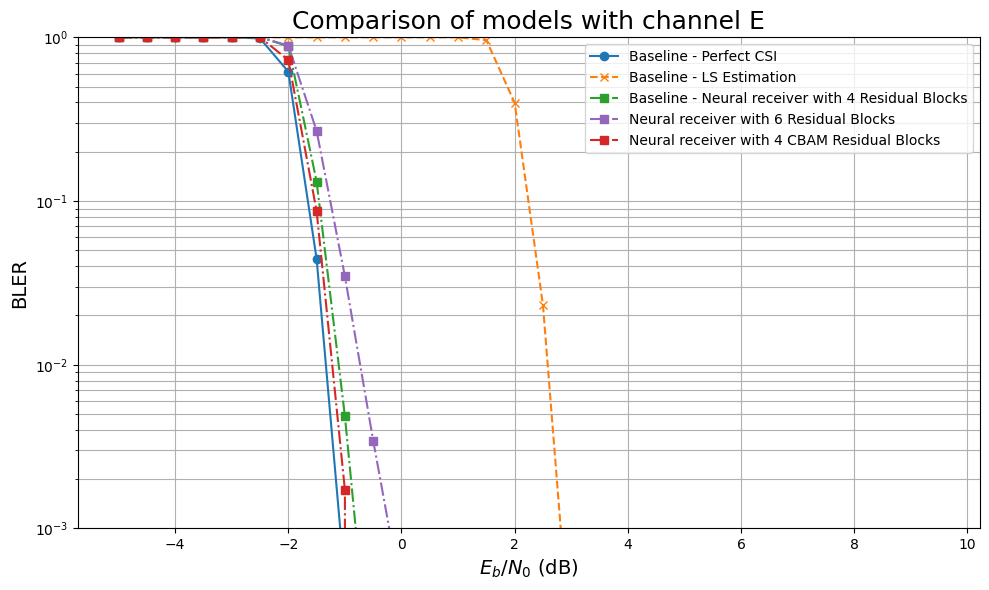

In [ ]:
plt.figure(figsize=(10,6))
# Baseline - Perfect CSI
plt.semilogy(ebno_dbs, BLER['baseline-perfect-csi-E'], 'o-', c=f'C0', label=f'Baseline - Perfect CSI')
# Baseline - LS Estimation
plt.semilogy(ebno_dbs, BLER['baseline-ls-estimation-E'], 'x--', c=f'C1', label=f'Baseline - LS Estimation')
# Neural receiver baseline
plt.semilogy(ebno_dbs, BLER['neural-receiver-baseline-E'], 's-.', c=f'C2', label=f'Baseline - Neural receiver with 4 Residual Blocks')
# Neural receiver deeper baseline
plt.semilogy(ebno_dbs, BLER['neural-receiver-baseline-deeper-E'], 's-.', c=f'C4', label=f'Neural receiver with 6 Residual Blocks')
# Neural receiver with attention
plt.semilogy(ebno_dbs, BLER['neural-receiver-CBAM-E'], 's-.', c=f'C3', label=f'Neural receiver with 4 CBAM Residual Blocks')

plt.title('Comparison of models with channel E', fontsize=18)
plt.xlabel(r"$E_b/N_0$ (dB)", fontsize=14)
plt.ylabel("BLER", fontsize=14)
plt.grid(which="both")
plt.ylim((1e-3, 1.0))
plt.legend()
plt.tight_layout()
plt.savefig('result_E.pdf', format='pdf')